In [3]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as BSoup
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
!pip install msgpack
!pip install geopy
from geopy.geocoders import Nominatim

!pip install folium 
import folium 

!pip install geocoder
import geocoder 

import seaborn as sns
import matplotlib.pyplot as plt

# London and NY Geodata

In [5]:
def get_geolocation(address):
  loc = Nominatim().geocode(address)
  geolocation = dict()
  geolocation['latitude'] = loc.latitude
  geolocation['longitude'] = loc.longitude
  return geolocation

In [7]:
"""
Using Nominatim from geopy.geocoders to fetch GeoLocation data on the basis of 
Location string
"""
nyc_loc = get_geolocation('New York City, NY')
nyc_geodata = dict()
nyc_geodata['City'] = 'NYC'
nyc_geodata['Latitude'] = nyc_loc['latitude']
nyc_geodata['Longitude'] = nyc_loc['longitude']

london_loc = get_geolocation('London, England')
london_geodata = dict()
london_geodata['City'] = 'London'
london_geodata['Latitude'] = london_loc['latitude']
london_geodata['Longitude'] = london_loc['longitude']


/home/jupyterlab/conda/lib/python3.6/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning
/home/jupyterlab/conda/lib/python3.6/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent

In [8]:
CLIENT_ID = 'SMNETOO2A5RQJK5JGSRAPJIV5444JMP2WJIXHTFLJ0GZLPQS'
CLIENT_SECRET = 'QHDB4QGRBDNEQNG5PUPIXYMWVUUHYCLRYQPHQUYZVFHRZVTQ'
VERSION = '20181026'
LIMIT = 200

In [9]:
def getNearbyVenues(names, lat, lng, radius=500):

  venues_list=[]
#   for name, lat, lng in zip(names, latitudes, longitudes):
  name = names.split(',')[0]
#   print(name)

  # create the API request URL
  url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
      CLIENT_ID, 
      CLIENT_SECRET, 
      VERSION, 
      lat, 
      lng, 
      radius, 
      LIMIT)

  # make the GET request
  results = requests.get(url).json()["response"]['groups'][0]['items']
#   print(results)

  # return only relevant information for each nearby venue
  venues_list.append([(

      v['venue']['name'], 
      str(v['venue']['location']['lat']), 
      str(v['venue']['location']['lng']),  
      v['venue']['categories'][0]['name']) for v in results])

  nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
  nearby_venues.columns = [
                'Venue', 
                'Latitude', 
                'Longitude', 
                'Venue Category']

  return(nearby_venues)

## Import Data Venues

In [10]:
nyc_venues = getNearbyVenues(names=nyc_geodata['City'], lat=nyc_geodata['Latitude'], lng=nyc_geodata['Longitude'])
london_venues = getNearbyVenues(names=london_geodata['City'], lat=london_geodata['Latitude'], lng=london_geodata['Longitude'])

In [11]:
nyc_geoloc_groups = (nyc_venues.groupby('Venue Category').apply(lambda x: [i for i in map(lambda p, q: (p,q), x.Latitude, x.Longitude)]).reset_index())
nyc_geoloc_groups.rename(columns={0: 'Coordinates_NYC'}, inplace=True)
print(nyc_geoloc_groups.head(3))

london_geoloc_groups = (london_venues.groupby('Venue Category').apply(lambda y: [i for i in map(lambda p, q: (p,q), y.Latitude, y.Longitude)]).reset_index())
london_geoloc_groups.rename(columns={0: 'Coordinates_London'}, inplace=True)
print(london_geoloc_groups.head(3))

        Venue Category                             Coordinates_NYC
0  American Restaurant  [(40.731155872068506, -73.98872764725327)]
1  Arts & Crafts Store  [(40.729961572238864, -73.98509847052101)]
2     Asian Restaurant  [(40.731718325211304, -73.98555396792241)]
       Venue Category                                 Coordinates_London
0   Accessories Store         [(51.511062857452046, -0.126267671585083)]
1  African Restaurant        [(51.51088902484121, -0.12700505770054704)]
2         Art Gallery  [(51.50943806358441, -0.1280324346985737), (51...


## Merge NYC geodata

In [12]:
nyc_venue_catg_grouped = nyc_venues.groupby('Venue Category').count().reset_index()
nyc_venue_groups = (nyc_venues.groupby('Venue Category').apply(lambda x: ','.join(x.Venue)).reset_index())
nyc_venue_grouped = (nyc_venue_catg_grouped.sort_values('Venue', ascending=False))[['Venue Category', 'Venue']]

nyc_venue_grouped.rename(columns={'Venue': 'Count_NYC'}, inplace=True)
nyc_venue_groups.rename(columns={0: 'Venues_NYC'}, inplace=True)

nyc_count_venues = pd.merge(nyc_venue_groups, nyc_venue_grouped, on="Venue Category", how="inner")
# print(nyc_merged_venues.sort_values('Count_NYC', ascending=False).head(5))

nyc_count_data = pd.merge(nyc_count_venues, nyc_geoloc_groups, on="Venue Category", how="inner")
nyc_count_data
# print(list(nyc_venue_groups.loc[5]))

,Venue Category,Venues_NYC,Count_NYC,Coordinates_NYC
0,American Restaurant,The Smith,1,"[(40.731155872068506, -73.98872764725327)]"
1,Arts & Crafts Store,Casey Rubber Stamp,1,"[(40.729961572238864, -73.98509847052101)]"
2,Asian Restaurant,Momofuku Ssäm Bar,1,"[(40.731718325211304, -73.98555396792241)]"
3,BBQ Joint,Mighty Quinn's BBQ,1,"[(40.7275688, -73.9886284)]"
4,Bagel Shop,"Tompkins Square Bagels,Black Seed Bagels",2,"[(40.73078120066792, -73.98602706997711), (40...."
5,Bakery,Veniero’s Pasticceria & Caffe,1,"[(40.72956613527381, -73.98443484606442)]"
6,Bar,"The Belfry,Ferns",2,"[(40.73286245412899, -73.98630004553797), (40...."
7,Beer Garden,Milk & Hops,1,"[(40.73140685915533, -73.99174677771859)]"
8,Bookstore,Strand Bookstore,1,"[(40.73320178975766, -73.99096009548717)]"
9,Burger Joint,Shake Shack,1,"[(40.72999845323382, -73.9896956893842)]"


## Merge London Geodata

In [13]:
london_venue_catg_grouped = london_venues.groupby('Venue Category').count().reset_index()
london_venue_groups = (london_venues.groupby('Venue Category').apply(lambda x: ','.join(x.Venue)).reset_index())
london_venue_grouped = (london_venue_catg_grouped.sort_values('Venue', ascending=False))[['Venue Category', 'Venue']]

london_venue_grouped.rename(columns={'Venue': 'Count_London'}, inplace=True)
london_venue_groups.rename(columns={0: 'Venues_London'}, inplace=True)

london_count_venues = pd.merge(london_venue_groups, london_venue_grouped, on="Venue Category", how="inner")
# print((london_venue_groups.loc[27])[1].split(','))

london_count_data = pd.merge(london_count_venues, london_geoloc_groups, on="Venue Category", how="inner")
london_count_data
# print(london_merged_venues.sort_values('Count_London', ascending=False).head(5))

,Venue Category,Venues_London,Count_London,Coordinates_London
0,Accessories Store,Laird Hats Caps,1,"[(51.511062857452046, -0.126267671585083)]"
1,African Restaurant,Koshari Street,1,"[(51.51088902484121, -0.12700505770054704)]"
2,Art Gallery,"National Portrait Gallery,Institute of Contemp...",3,"[(51.50943806358441, -0.1280324346985737), (51..."
3,Art Museum,National Gallery,1,"[(51.50887601013219, -0.1284778118133545)]"
4,Arts & Crafts Store,Cass Art,1,"[(51.51009713987883, -0.12832854321880532)]"
5,Bakery,Ole & Steen,1,"[(51.509219114319954, -0.1325971590898062)]"
6,Bar,The London Beer House,1,"[(51.50821434015014, -0.13257835254245434)]"
7,Bookstore,"Waterstones,National Gallery Bookshop,Watkins ...",3,"[(51.50764972496243, -0.12712953878194402), (5..."
8,Boutique,Dover Street Market,1,"[(51.508995574874795, -0.13212434502786355)]"
9,Breakfast Spot,Fernando's,1,"[(51.510838778229626, -0.1270446153953111)]"


## Combine London and NYC geodata

In [14]:
combined_count_data = pd.merge(nyc_count_data, london_count_data, on="Venue Category", how="inner")
combined_count_data

,Venue Category,Venues_NYC,Count_NYC,Coordinates_NYC,Venues_London,Count_London,Coordinates_London
0,Arts & Crafts Store,Casey Rubber Stamp,1,"[(40.729961572238864, -73.98509847052101)]",Cass Art,1,"[(51.51009713987883, -0.12832854321880532)]"
1,Bakery,Veniero’s Pasticceria & Caffe,1,"[(40.72956613527381, -73.98443484606442)]",Ole & Steen,1,"[(51.509219114319954, -0.1325971590898062)]"
2,Bar,"The Belfry,Ferns",2,"[(40.73286245412899, -73.98630004553797), (40....",The London Beer House,1,"[(51.50821434015014, -0.13257835254245434)]"
3,Bookstore,Strand Bookstore,1,"[(40.73320178975766, -73.99096009548717)]","Waterstones,National Gallery Bookshop,Watkins ...",3,"[(51.50764972496243, -0.12712953878194402), (5..."
4,Burger Joint,Shake Shack,1,"[(40.72999845323382, -73.9896956893842)]","Five Guys,Byron,Byron",3,"[(51.50853250848257, -0.1244745041598511), (51..."
5,Café,"Mudspot,Saltwater Coffee",2,"[(40.7290704479652, -73.98681104426099), (40.7...","Café In The Crypt,Portrait Restaurant",2,"[(51.50896230356763, -0.12672904352900202), (5..."
6,Coffee Shop,"Hi-Collar - ハイカラ (Hi-Collar),Third Rail Coffee...",4,"[(40.729449019976, -73.98591848402724), (40.72...","Notes Music & Coffee,The Espresso Room",2,"[(51.509696003098284, -0.12698537841552573), (..."
7,Greek Restaurant,Taverna Kyclades,1,"[(40.73117860451496, -73.98271881421127)]",Milos,1,"[(51.50811719446084, -0.13334124484466278)]"
8,Ice Cream Shop,"Sundaes and Cones,Fresco Gelateria,Snowdays Sh...",6,"[(40.7309885617057, -73.98939013481139), (40.7...","Amorino,La Gelatiera,Amorino",3,"[(51.51042726621419, -0.12840081492921637), (5..."
9,Japanese Restaurant,"Kotobuki,Ikinari Steak,Taishu-Izakaya Kenka,Oh...",4,"[(40.73103729924171, -73.98886456133741), (40....","Japan Centre,Machiya",2,"[(51.509760861810946, -0.13127297164342394), (..."


## Cluster Data

In [16]:
k_cluster_num = 5
columns = ['NYC_Venue_Count', 'London_Venue_Count']
data_temp = {'NYC_Venue_Count': combined_count_data['Count_NYC'], 'London_Venue_Count': combined_count_data['Count_London']}
# print(london_venue_grouped['Venue'])
data_temp_df = pd.DataFrame(data_temp, columns=columns)
print(data_temp_df)
k_means_count = KMeans(n_clusters=k_cluster_num, random_state=0).fit(data_temp_df)
print(k_means_count.labels_)

    NYC_Venue_Count  London_Venue_Count
0                 1                   1
1                 1                   1
2                 2                   1
3                 1                   3
4                 1                   3
5                 2                   2
6                 4                   2
7                 1                   1
8                 6                   3
9                 4                   2
10                2                   1
11                5                   1
12                1                   3
13                2                   1
14                1                   2
15                1                   2
16                1                   1
17                1                   2
18                1                   3
19                1                   1
[3 3 1 0 0 1 2 3 4 2 1 2 0 1 0 0 3 0 0 3]


## Merge cluster/count data

In [17]:
count_combined = combined_count_data
count_combined['Cluster Labels'] = k_means_count.labels_
print(count_combined.head(3))

        Venue Category                     Venues_NYC  Count_NYC  \
0  Arts & Crafts Store             Casey Rubber Stamp          1   
1               Bakery  Veniero’s Pasticceria & Caffe          1   
2                  Bar               The Belfry,Ferns          2   

                                     Coordinates_NYC          Venues_London  \
0         [(40.729961572238864, -73.98509847052101)]               Cass Art   
1          [(40.72956613527381, -73.98443484606442)]            Ole & Steen   
2  [(40.73286245412899, -73.98630004553797), (40....  The London Beer House   

   Count_London                           Coordinates_London  Cluster Labels  
0             1  [(51.51009713987883, -0.12832854321880532)]               3  
1             1  [(51.509219114319954, -0.1325971590898062)]               3  
2             1  [(51.50821434015014, -0.13257835254245434)]               1  


In [18]:
nyc_venues_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix='', prefix_sep='')
# print(nyc_venues_onehot)

nyc_venues_onehot['Venue Category'] = nyc_venues['Venue Category']
# nyc_venues_onehot
nyc_venues_grouped_mean = nyc_venues_onehot.groupby('Venue Category').mean().reset_index()

nyc_mean_data = pd.merge(nyc_venues_grouped_mean, nyc_geoloc_groups, on="Venue Category", how="inner")

nyc_venues_mean_temp = nyc_venues_grouped_mean.drop('Venue Category', 1)
k_means_avg_nyc = KMeans(n_clusters=k_cluster_num, random_state=0).fit(nyc_venues_mean_temp)
nyc_mean_merged = nyc_venues_grouped_mean
nyc_mean_merged['Cluster Labels'] = k_means_avg_nyc.labels_
nyc_mean_merged = pd.merge(nyc_mean_merged[['Venue Category', 'Cluster Labels']], nyc_venues_onehot, on='Venue Category', how='inner')
nyc_mean_merged = pd.merge(nyc_mean_merged, nyc_venues[['Venue Category', 'Venue', 'Latitude', 'Longitude']], on='Venue Category', how='inner')
nyc_mean_merged.drop_duplicates(inplace=True)

In [19]:
london_venues_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix='', prefix_sep='')
# print(london_venues_onehot)

london_venues_onehot['Venue Category'] = london_venues['Venue Category']
london_venues_grouped_mean = london_venues_onehot.groupby('Venue Category').mean().reset_index()

london_mean_data = pd.merge(london_venues_grouped_mean, london_geoloc_groups, on="Venue Category", how="inner")

london_venues_mean_temp = london_venues_grouped_mean.drop('Venue Category', 1)
k_means_avg_london = KMeans(n_clusters=k_cluster_num, random_state=0).fit(london_venues_mean_temp)
london_mean_merged = london_venues_grouped_mean
london_mean_merged['Cluster Labels'] = k_means_avg_london.labels_
london_mean_merged = pd.merge(london_mean_merged[['Venue Category', 'Cluster Labels']], london_venues_onehot, on='Venue Category', how='inner')
# london_mean_merged[['Venue Category', 'Cluster Labels']]
london_mean_merged = pd.merge(london_mean_merged, london_venues[['Venue Category', 'Venue', 'Latitude', 'Longitude']], on='Venue Category', how='inner')
london_mean_merged.drop_duplicates(inplace=True)

## Visualize venues for London/NYC

In [20]:
def create_city_map(merged_data, geoloc_data, common_data):
  base_lat = geoloc_data['Latitude']
  base_lng = geoloc_data['Longitude']
  map_clusters = folium.Map(location=[base_lat, base_lng], zoom_start=16)

  # set color scheme for the clusters
  x = np.arange(k_cluster_num)
  ys = [i+x+(i*x)**2 for i in range(k_cluster_num)]
  colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
  rainbow = [colors.rgb2hex(i) for i in colors_array]

  # add markers to the map
  markers_colors = []
  for lat, lon, poi, cluster, categ in zip(merged_data['Latitude'], merged_data['Longitude'], merged_data['Venue'], merged_data['Cluster Labels'], merged_data['Venue Category']):
    label = folium.Popup('{} ({}) - Cluster {}'.format(str(poi), categ, str(cluster)), parse_html=True)
    folium.CircleMarker(
        [float(lat), float(lon)],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

  return map_clusters

In [21]:
nyc_overall_map = create_city_map(nyc_mean_merged, nyc_geodata, count_combined)
nyc_overall_map

In [22]:
london_overall_map = create_city_map(london_mean_merged, london_geodata, count_combined)
london_overall_map

In [23]:
""" 
Creating map of Cities's Neighborhood using Folium
"""

# defining the Folium Map in a function
def create_map(city_data, geoloc_data):
  base_lat = float(geoloc_data['Latitude'])
  base_lng = float(geoloc_data['Longitude'])
  map_clusters = folium.Map(location=[base_lat, base_lng], zoom_start=16)

  # set color scheme for the clusters

  rainbow = ['#F84583', '#4868F7', '#53DEE8', '#00F950', '#F9FA20']
  geodata_param = city_data['Coordinates_{}'.format(geoloc_data['City'])]
  venue_param = city_data['Venues_{}'.format(geoloc_data['City'])]

  # add markers to the map
  markers_colors = []

  for geo_data, venues, cluster, categ in zip(geodata_param, venue_param, city_data['Cluster Labels'], city_data['Venue Category']):
#     print('{}: [{}] - cluster {}'.format(venues, geo_data, cluster))
    for geoloc, poi in zip(geo_data, venues.split(',')):
#       print('{1}: {0}'.format(geoloc, poi))
      label = folium.Popup(str(poi) + ' ( {} ) - Cluster {}'.format(categ, str(cluster)), parse_html=True)
      folium.CircleMarker(
          [float(geoloc[0]), float(geoloc[1])],
          radius=5,
          popup=label,
          color=rainbow[cluster-1],
          fill=True,
          fill_color=rainbow[cluster-1],
          fill_opacity=1).add_to(map_clusters)
  return map_clusters

In [24]:
nyc_cluster_map = create_map(count_combined, nyc_geodata)
nyc_cluster_map

## NYC cluster analysis

In [25]:
first_cluster = count_combined.loc[count_combined['Cluster Labels'] == 0, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(first_cluster.shape[0])
nyc_first_cluster = create_map(first_cluster, nyc_geodata)
nyc_first_cluster

7


In [26]:
second_cluster = count_combined.loc[count_combined['Cluster Labels'] == 1, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(len(second_cluster))
nyc_second_cluster = create_map(second_cluster, nyc_geodata)
nyc_second_cluster

4


In [27]:
third_cluster = count_combined.loc[count_combined['Cluster Labels'] == 2, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(len(third_cluster))
nyc_third_cluster = create_map(third_cluster, nyc_geodata)
nyc_third_cluster

3


In [28]:
fourth_cluster = count_combined.loc[count_combined['Cluster Labels'] == 3, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(len(fourth_cluster))
nyc_fourth_cluster = create_map(fourth_cluster, nyc_geodata)
nyc_fourth_cluster

5


In [29]:
fifth_cluster = count_combined.loc[count_combined['Cluster Labels'] == 4, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(fifth_cluster.shape[0])
nyc_fifth_cluster = create_map(fifth_cluster, nyc_geodata)
nyc_fifth_cluster

1


In [30]:
london_cluster_map = create_map(count_combined, london_geodata)
london_cluster_map

## London Cluster Analysis

In [31]:
first_cluster = count_combined.loc[count_combined['Cluster Labels'] == 0, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(first_cluster.shape[0])
london_first_cluster = create_map(first_cluster, london_geodata)
london_first_cluster

7


In [32]:
second_cluster = count_combined.loc[count_combined['Cluster Labels'] == 1, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(second_cluster.shape[0])
london_second_cluster = create_map(second_cluster, london_geodata)
london_second_cluster

4


In [33]:
third_cluster = count_combined.loc[count_combined['Cluster Labels'] == 2, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(third_cluster.shape[0])
london_third_cluster = create_map(third_cluster, london_geodata)
london_third_cluster

3


In [34]:
fourth_cluster = count_combined.loc[count_combined['Cluster Labels'] == 3, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(fourth_cluster.shape[0])
london_fourth_cluster = create_map(fourth_cluster, london_geodata)
london_fourth_cluster

5


In [35]:
fifth_cluster = count_combined.loc[count_combined['Cluster Labels'] == 4, count_combined.columns[[0] + list(range(1, count_combined.shape[1]))]]
print(fifth_cluster.shape[0])
london_fifth_cluster = create_map(fifth_cluster, london_geodata)
london_fifth_cluster

1


## Initiate Visualizations

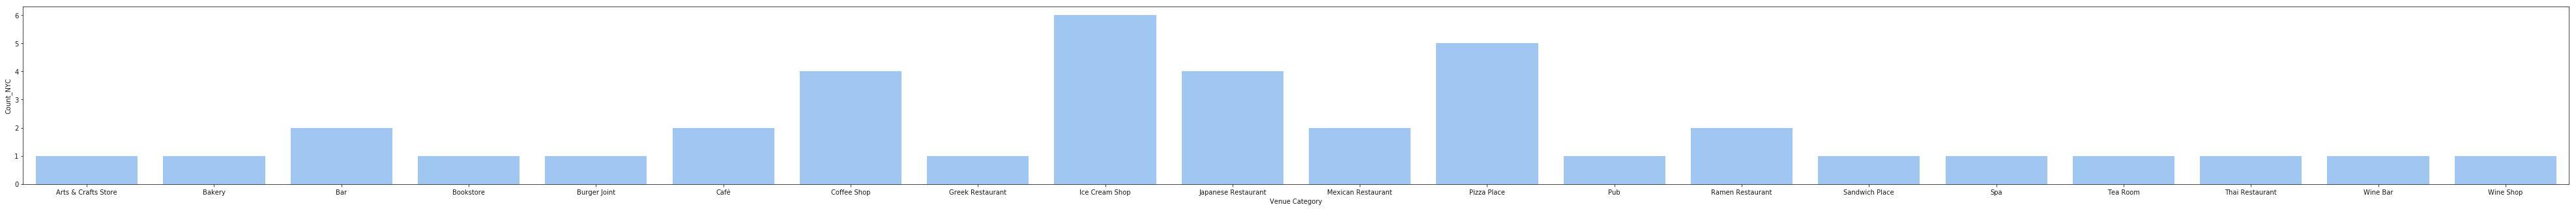

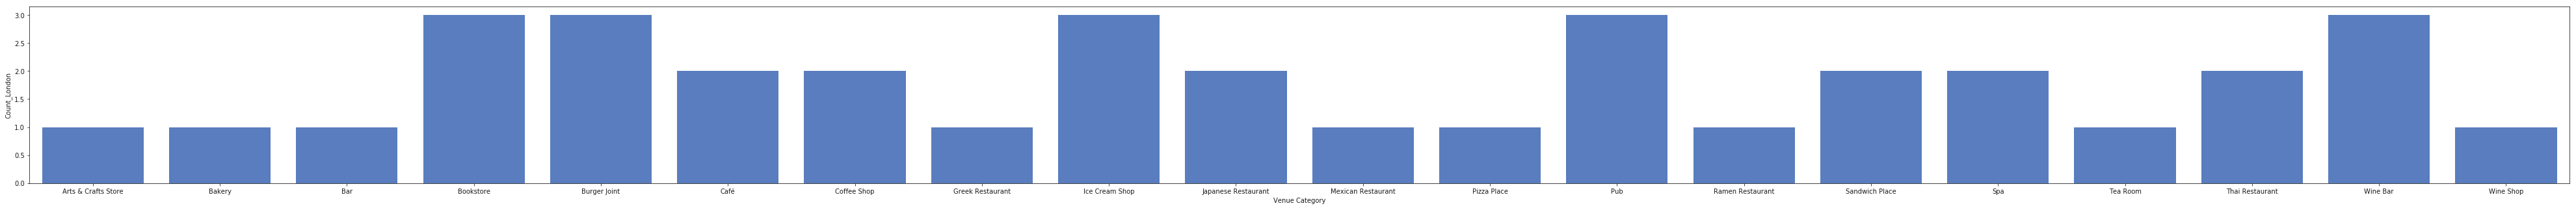

In [36]:
plt.figure(figsize=(70,5))
sns.set_color_codes("pastel")
sns.barplot(x='Venue Category', y='Count_NYC', data=count_combined, color='b', label='New York City', )

plt.figure(figsize=(70,5))
sns.set_color_codes("muted")
sns.barplot(x='Venue Category', y='Count_London', data=count_combined, color='b', label='London City')

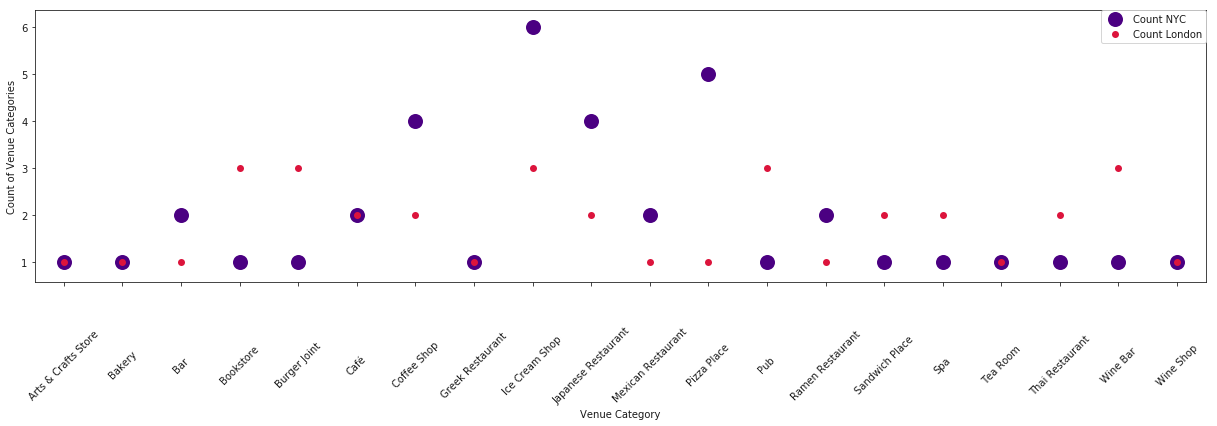

In [37]:
handles = list()
labels = list()
plt.figure(figsize=(21, 5))

sns.set_color_codes("pastel")

ax = sns.stripplot(x='Venue Category', y='Count_NYC', data=count_combined,palette=['indigo'],size=15, label='Count NYC')

handle, label = ax.get_legend_handles_labels()
handles.append(handle[0])
labels.append(label[0])

ax.set_xticklabels(list(count_combined['Venue Category']), rotation = 45, va="center", position=(0,-0.28))

sns.set_color_codes("muted")

ax1 = sns.stripplot(x='Venue Category', y='Count_London', data=count_combined, palette=['crimson'], size=7, label='Count London')

handle1, label1 = ax1.get_legend_handles_labels()

handles.append(handle1[len(handle)+1])
labels.append(label1[len(label)+1])

plt.ylabel('Count of Venue Categories')

plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)